# 高斯玻色采样模拟分子振动激发

分子中振动模式的激发会影响化学反应的结果。
振动激发可以为分子提供额外的动能，以克服特定反应的能量壁垒，并有助于控制分子的稳定性。
然而，对涉及分子振动和电子态同时变化的过程进行所有振动能级激发概率模拟是具有挑战性的。
本例中，我们演示如何使用高斯玻色取样（GBS）来模拟分子振动激发。

### 甲酸分子的振动激发

In [1]:
import deepquantum as dq
import matplotlib.pyplot as plt
import numpy as np

我们还需要描述分子振动模式和分子在振动跃迁过程中几何结构变化的分子参数。
这些参数由杜辛斯基矩阵和位移向量表示，这些参数是从原子坐标、原子质量、振动频率以及分子的正常模式获得的。
这些分子参数可以通过电子结构计算获得。

$1^1A'$ 态及$1^2A'$ 态的平衡结构坐标如下

In [2]:
ri = np.genfromtxt("./data/formic_ri.csv", delimiter=",", skip_header=0)[:, np.newaxis]
rf = np.genfromtxt("./data/formic_rf.csv", delimiter=",", skip_header=0)[:, np.newaxis]

$1^1A'$ 态及 $1^2A'$ 态的质量加权简正坐标如下

In [3]:
li = np.genfromtxt("./data/formic_li.csv", delimiter=",", skip_header=0)
lf = np.genfromtxt("./data/formic_lf.csv", delimiter=",", skip_header=0)

$1^1A'$ 态及 $1^2A'$ 态简正模式频率如下

In [4]:
omega = np.genfromtxt("./data/formic_omega.csv", delimiter=",", skip_header=0)
omegap = np.genfromtxt("./data/formic_omegap.csv", delimiter=",", skip_header=0)

计算中用到的物理学常量

In [5]:
c = 299792458.0  # 光速
mu = 1.6605390666 * 10**-27  # 原子质量单位
h = 6.62607015 * 10**-34  # 普朗克常数

m_c = 12  # 碳原子相对原子质量
m_h = 1.007825037  # 氢原子相对原子质量
m_o = 15.994914640  # 氧原子相对原子质量

Duschinsky 矩阵 $U$ 及位移矢量 $\delta$ 计算如下

In [6]:
u = []
for li_ele in li:
    for lf_elf in lf:
        u.append(np.sum(li_ele * lf_elf))
u = np.array(u[-1::-1]).reshape(7, 7).T
u

array([[ 0.99343181,  0.01440011,  0.01532633,  0.02861045,  0.06378083,
         0.07513988, -0.04280796],
       [-0.01485231,  0.99314303,  0.07419536,  0.0769291 , -0.03610189,
        -0.00248855,  0.01727882],
       [-0.01185718, -0.09164895,  0.84227531,  0.17994129, -0.38567948,
         0.30738928,  0.08008576],
       [ 0.03813492,  0.04087165, -0.34031972, -0.52311845, -0.66785609,
         0.38477092,  0.11420873],
       [-0.04133251, -0.03419326, -0.40036477,  0.76362651, -0.10356638,
         0.48381836,  0.09406589],
       [ 0.0907918 , -0.04184572, -0.09066643,  0.31511355, -0.59003401,
        -0.719268  ,  0.13037051],
       [-0.03245558,  0.00500992, -0.02063661,  0.06935002, -0.20181377,
         0.01732396, -0.97588364]])

In [7]:
delta = []
m = np.diag([m_c, m_c, m_c, m_o, m_o, m_o, m_o, m_o, m_o, m_h, m_h, m_h, m_h, m_h, m_h])
for i in range(len(omegap)):
    d = lf[i].T @ np.sqrt(m) @ (ri - rf)
    l = np.sqrt(h / (4 * np.pi**2 * 100 * omegap[i] * c * mu)) / (10**-10)
    delta.append(d / l)
delta = np.array(delta[-1::-1])
delta

array([[ 0.22536617],
       [ 0.14689208],
       [ 1.55989779],
       [-0.37838396],
       [ 0.45525871],
       [-0.34391138],
       [ 0.06184607]])

Duschinsky矩阵非对角元素描述了不同电子态之间简正模式的混合情况

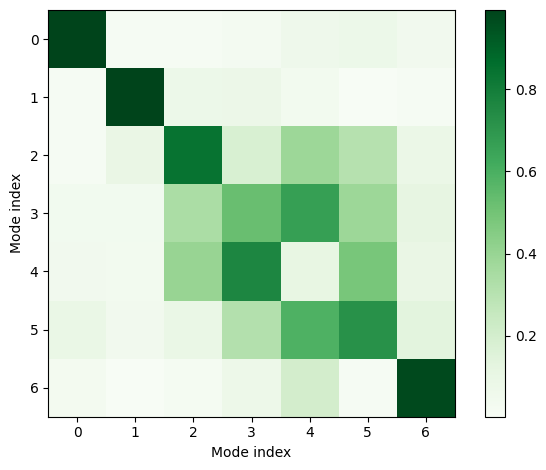

In [8]:
plt.imshow(abs(u), cmap="Greens")
plt.colorbar()
plt.xlabel("Mode index")
plt.ylabel("Mode index")
plt.tight_layout()
plt.show()

非对角元素的存在显示了不同电子态之间简正模式的混合。
由 Duschinsky 矩阵和位移向量计算 GBS 参数如下：

In [9]:
pre_transition_squeezing = np.sqrt(omega[-1::-1])
post_transition_squeezing = np.sqrt(omegap[-1::-1])

j_mat = (
    np.diag(post_transition_squeezing)
    @ u
    @ np.linalg.inv(np.diag(pre_transition_squeezing))
)

cl, lambda_1, cr = np.linalg.svd(j_mat)

delta_2 = np.linalg.inv(j_mat) @ delta / np.sqrt(2)
delta_2 = delta_2.flatten()
lambda_2 = np.log(lambda_1)

我们现在可以计算每个振动模式中的平均振动量子数

In [10]:
modes = 7  # 简正模式数量
cutoff = 3
shots = 500000

In [11]:
cir = dq.photonic.QumodeCircuit(
    nmode=modes,
    init_state="vac",
    # init_state=init_state,
    cutoff=cutoff,
    backend="gaussian",
)

for i in range(modes):
    cir.d(wires=[i], r=delta_2[i])

cir.any(cr, wires=list(range(modes)))

for i in range(modes):
    cir.s(wires=[i], r=-lambda_2[i])

cir.any(cl, wires=list(range(modes)))

state = cir()

# 线路可视化
cir.draw()

In [13]:
sample = cir.measure(shots=shots, mcmc=True)

Using MCMC method to sample the final states!


chain 5: 100%|█████████████████████████| 99999/99999 [00:01<00:00, 91211.59it/s]


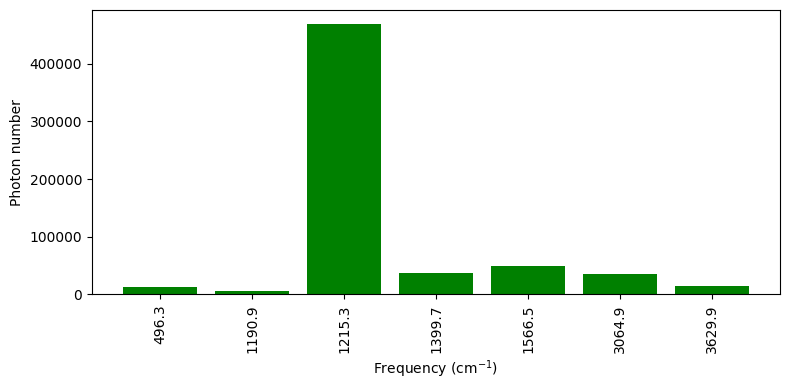

In [14]:
sample2 = []
for ele in sample.items():
    # print(ele[0].state)
    sample2.append(ele[0].state * ele[1])
counts2 = np.sum(sample2, axis=0)

plt.figure(figsize=(8, 4))
plt.ylabel("Photon number")
plt.xlabel(r"Frequency (cm$^{-1}$)")
plt.xticks(range(len(omegap)), np.round(omegap, 1), rotation=90)
plt.bar(range(len(omegap)), counts2, color="green")
plt.tight_layout()
plt.show()

现在模拟一个光激发过程，其中涉及从电子基态的预激发振动态进行振动跃迁。
预激发振动态可以通过应用位移门来模拟。
我们向第6个振动模式插入平均一个振动量子，并计算激发电子态中每个振动模式的平均光子数。

In [15]:
cir = dq.photonic.QumodeCircuit(
    nmode=modes,
    init_state="vac",
    # init_state=init_state,
    cutoff=cutoff,
    backend="gaussian",
)

cir.d(wires=[5], r=1.0)

for i in range(modes):
    cir.d(wires=[i], r=delta_2[i])

cir.any(cr, wires=list(range(modes)))

for i in range(modes):
    cir.s(wires=[i], r=-lambda_2[i])

cir.any(cl, wires=list(range(modes)))

state = cir()

# 线路可视化
cir.draw()

In [16]:
sample3 = cir.measure(shots=shots, mcmc=True)

Using MCMC method to sample the final states!


chain 5: 100%|█████████████████████████| 99999/99999 [00:01<00:00, 91817.58it/s]


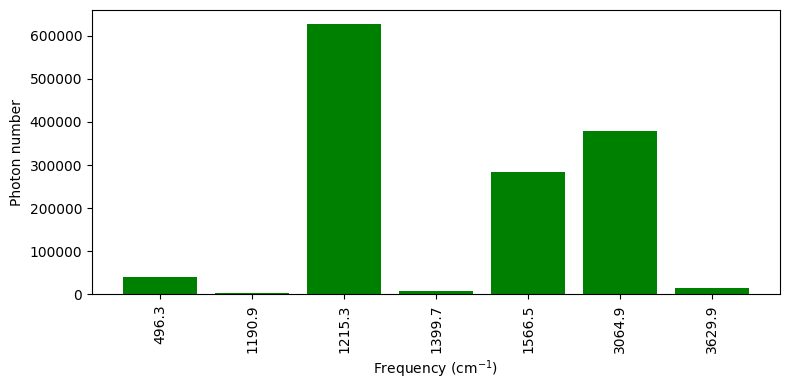

In [17]:
sample4 = []
for ele in sample3.items():
    # print(ele[0].state)
    sample4.append(ele[0].state * ele[1])
counts4 = np.sum(sample4, axis=0)

plt.figure(figsize=(8, 4))
plt.ylabel("Photon number")
plt.xlabel(r"Frequency (cm$^{-1}$)")
plt.xticks(range(len(omegap)), np.round(omegap, 1), rotation=90)
plt.bar(range(len(omegap)), counts4, color="green")
plt.tight_layout()
plt.show()